In [1]:
import json
import pandas as pd

repo_profiles = {}
repo_teams = {}
with open('repo_profiles.json') as rj:
    for rl in rj.readlines():
        line = rl.split('\t')
        repo = line[0]
        profile = json.loads(line[1])
        repo_profiles[repo] = profile
        repo_teams[repo] = repo_profiles[repo].pop('teams')
    
team_profiles = []
teams = []
with open('team_profiles.json') as tj:
    for tl in tj.readlines():
        line = tl.split('\t')
        team = line[0]
        profile = json.loads(line[1])
        team_profiles.append(profile)
        teams.append(team)

In [2]:
repo_profiles_df = pd.DataFrame(repo_profiles).transpose()
repo_profiles_df.fillna('',inplace=True)
team_profiles_df = pd.DataFrame(team_profiles,index=teams)
team_profiles_df.rename(columns={
                                   'repo_size':'size',
                                   'repo_forks':'forks',
                                   'repo_subscribers':'subscribers',
                                   'repo_watchers':'watchers',
                                   'languages':'languages',
                                   'topics':'topics'
                               },inplace=True)

numerics = ['size','forks','subscribers','watchers']

In [3]:
repo_profiles_df[numerics].hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001C3EF0DBC88>,
      dtype=object)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001C3F8FCD748>,
      dtype=object)

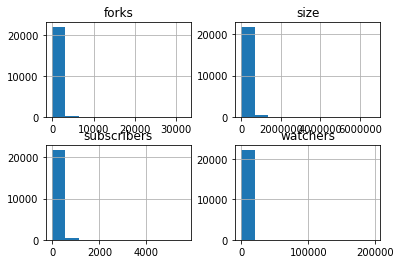

In [4]:
team_profiles_df[numerics].hist()

In [5]:
min = repo_profiles_df[numerics].min()
max = repo_profiles_df[numerics].max()
repo_profiles_df[numerics] = (repo_profiles_df[numerics]-min)/(max-min)
team_profiles_df[numerics] = (team_profiles_df[numerics]-min)/(max-min)

print(repo_profiles_df.iloc[0])
print(team_profiles_df.iloc[0])

forks                                            0.000827615
languages         [Shell, HTML, CSS, JavaScript, Dockerfile]
size                                              6.3607e-05
subscribers                                       0.00178486
topics         [ember, screwdriver, ui, continuous-delivery]
watchers                                         3.37048e-05
Name: screwdriver-cd/ui, dtype: object
languages            [CSS, HTML]
forks                          0
size                 5.66759e-06
subscribers          0.000118991
watchers                       0
target         StarryPy/StarryPy
topics                        []
Name: ["AMorporkian", "kharidiron"], dtype: object


In [6]:
repo_profiles_df.describe()

,forks,size,subscribers,watchers
count,14242.000000,14242.000000,14242.000000,14242.000000
mean,0.007300,0.001259,0.008071,0.002878
std,0.032253,0.009800,0.028054,0.017179
min,0.000000,0.000000,0.000000,0.000000
25%,0.000172,0.000021,0.000952,0.000013
50%,0.000966,0.000128,0.002499,0.000118
75%,0.003655,0.000718,0.006069,0.000927
max,1.000000,1.000000,1.000000,1.000000


In [7]:
team_profiles_df.describe()

,forks,size,subscribers,watchers
count,22330.000000,2.233000e+04,22330.000000,22330.000000
mean,0.013568,1.720402e-03,0.011914,0.004737
std,0.034628,4.398662e-03,0.023722,0.015095
min,0.000000,1.985461e-07,0.000000,0.000000
25%,0.001224,1.669288e-04,0.002538,0.000150
50%,0.004552,5.566098e-04,0.005593,0.001011
75%,0.013471,1.531566e-03,0.012301,0.004406
max,1.103756,1.211710e-01,0.668134,0.666754


In [8]:
import numpy as np

def euclidean_distance(p1,p2):
    distance = np.linalg.norm(p1[numerics]-p2[numerics])**2
    langs = set(p1['languages']).union(p2['languages'])
    topics = set(p1['topics']).union(p2['topics'])
    p1_langs = pd.Series([lang in p1['languages'] for lang in langs])/np.sqrt(len(langs))
    p2_langs = pd.Series([lang in p2['languages'] for lang in langs])/np.sqrt(len(langs))
    p1_topics = pd.Series([topic in p1['topics'] for topic in topics])/np.sqrt(len(topics))
    p2_topics = pd.Series([topic in p2['topics'] for topic in topics])/np.sqrt(len(topics))
    distance += np.linalg.norm(p1_langs-p2_langs)**2 + np.linalg.norm(p1_topics-p2_topics)**2
    distance = np.sqrt(distance)
    
    return distance
    
p1 = repo_profiles_df.iloc[0]
p2 = team_profiles_df.iloc[0]
print(euclidean_distance(p1,p2))

1.2649124335594584


In [9]:
from queue import PriorityQueue

team_recommendations = []
cnt = 0
for repo,repo_profile in repo_profiles_df.iterrows():
    cnt += 1
    if cnt > 1:
        break
    print(cnt)
    rec = []
    queue = PriorityQueue()
    for team,team_profile in team_profiles_df.iterrows():
        if team in repo_teams[repo]:
            continue
        dis = euclidean_distance(repo_profile,team_profile)
        queue.put_nowait((-dis,team))
        if queue.qsize() > 20:
            queue.get_nowait()
    while queue.qsize()>0:
        rec.append(queue.get_nowait())
    team_recommendations.append(rec)


1


In [10]:
for i,rec in enumerate(team_recommendations):
    print(repo_profiles_df.iloc[i].name,end='\t')
    for tm in rec:
        print(json.dumps(list(tm)),end='\t')
    print('\n')

screwdriver-cd/ui	[-1.0005736091016377, "[\"yeion7\", \"jlengstorf\", \"marisamorby\", \"mottox2\", \"nico29\", \"shinytoyrobots\"]"]	[-1.0002434789124999, "[\"garris\", \"shanemcgraw\"]"]	[-1.0001594986389972, "[\"rauchg\", \"millette\", \"albinekb\", \"mrmartineau\", \"chabou\", \"sergiodxa\", \"leo\", \"ntwcklng\", \"flybayer\", \"aurelienbottazini\", \"mikemcbride\", \"timothyis\", \"ppot\", \"brandonmp\", \"matheuss\", \"henrikdahl\", \"evilrabbit\", \"sreeramjayan\", \"sonnyg\", \"MAPESO\", \"neil-orans\"]"]	[-1.0000202689492503, "[\"LowProfileDog\", \"jimthoburn\", \"Taekyoon\", \"sanghisha145\"]"]	[-1.0000160678005583, "[\"Pheonix7284\", \"minimart\"]"]	[-1.0000124156162071, "[\"Antwnis\", \"chdask\", \"andmarios\", \"jglambed\"]"]	[-1.0000089474095646, "[\"spencern\", \"prosf\", \"duanhong169\", \"stevaras\", \"lcampanis\", \"rhenshaw56\", \"dancastellon\"]"]	[-1.0000057822136403, "[\"momchil-sap\", \"martin-d-aleksandrov\"]"]	[-1.0000041879656776, "[\"hexparrot\", \"Siliconhe